In [1]:
import numpy as np
import cirq
import matplotlib
from mitiq.interface.mitiq_qiskit.conversions import to_qiskit
from qiskit import IBMQ, transpile, Aer, assemble
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


#FUCTIONS
def int_to_binary(N,b):
    bit = format(b,'b')
    if len(bit)<N:
        for _ in range(N-len(bit)):bit = str(0)+bit
    return bit

def base(qubits):
    return cirq.Circuit(
            cirq.H(qubits[0]),
            *[cirq.CNOT(qubits[i - 1], qubits[i]) for i in range(1, len(qubits))],
            )

def measure(c,qubits):
    c.append(cirq.measure(*qubits, key='result'))
    return c


def bitGateMap(c,g,qi,qubits):
    '''Map X/Y/Z string to cirq ops'''
    if g=="X":
        c.append(cirq.H(qubits[qi]))
        
    elif g=="Y":
        sdg = cirq.S**-1
        c.append(sdg(qubits[qi]))
        c.append(cirq.H(qubits[qi]))
        
    elif g=="Z":
        pass
    else:
        raise NotImplementedError(f"Unknown gate {g}")
    

def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

def rotGate(g):
    if g=="X":
        return 1/np.sqrt(2)*np.array([[1.,1.],[1.,-1.]])

    elif g=="Y":
        return 1/np.sqrt(2)*np.array([[1.,-1.0j],[1.,1.j]])
    elif g=="Z":
        return np.eye(2)
    else:
        raise NotImplementedError(f"Unknown gate {g}")    
    

def obs_gate(g):
    if g=="X":
        return cirq.unitary(cirq.X)
    elif g=="Y":
        return cirq.unitary(cirq.Y)
    elif g=="Z":
        return cirq.unitary(cirq.Z)
    elif g=="I":
        return cirq.unitary(cirq.I)
    else:
        raise NotImplementedError(f"Unknown gate {g}")    

def trace_dist(lam_exact,rho):
    mid = (lam_exact-rho).conj().T@(lam_exact-rho)
    N = 2**int(np.log2(lam_exact.shape[0])/2)
    U1,d,U2 = np.linalg.svd(mid)
    sqrt_mid = U1@np.diag(np.sqrt(d))@U2
    dist = np.trace(sqrt_mid)/2
    return dist/N

def operator(string):
    op = 1.
    for o in string:
        op = np.kron(obs_gate(o),op)
    return op



def run_batch(circuit_array,count):
    circuit_array = np.split(np.array(circuit_array),len(circuit_array)//100+1)
    results =[]
    for circ in circuit_array:
        IBMQ.save_account("e4aa945798224dfeade112e32d48f89cb15250cef840990d434202d1be8e9dcb844c625cc48dd99c8ac022b7924e46855502882c03c90607bf01227cd6110822", overwrite=True) 
        provider = IBMQ.load_account()
        provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
        backend = provider.get_backend('ibmq_lima')    
        mapped_circuit = [transpile(ci, backend=backend) for ci in circ]
        qobj = assemble(mapped_circuit, backend=backend, shots=count)

        job = backend.run(qobj)
        result = job.result()
        counts = result.get_counts()
        for c in counts: results.append(c)
    return results


def find_rho_IBM(circuit,qubits,N=2,nsimu = 10000):

    gates= [np.random.choice(['X','Y','Z'],size=N) for _ in range(nsimu)]
    labels,counts = np.unique(gates,axis = 0, return_counts =True)
    results = []
    circuit_array =[]
    for bit_string,count in zip(labels,counts):
        c_m = circuit.copy()
        for i,bit in enumerate(bit_string): bitGateMap(c_m,bit,i,qubits) 
        measure(c_m,qubits) 
        c_m = to_qiskit(c_m)
        circuit_array.append(c_m)
    
    results = run_batch(circuit_array,count=2000)
    'Shadow Tomography part'
    shadows = []
    shots = 0
    for pauli_string,counts in zip(labels,results):
        for bit,count in counts.items():
            mat = 1.
            for i,bi in enumerate(bit[::-1]):
                b = rotGate(pauli_string[i])[int(bi),:]
                mat = np.kron(Minv(1,np.outer(b.conj(),b)),mat)
            shadows.append(mat*count)
            shots+=count

    return np.sum(shadows,axis=0)/(shots)




[cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(3), cirq.LineQubit(4)]
0: ───H───@───────────────
          │
1: ───────X───@───────────
              │
2: ───────────X───@───────
                  │
3: ───────────────X───@───
                      │
4: ───────────────────X───
START ACCOUNT
START ACCOUNT


ibmqfactory.load_account:WARNING:2023-06-01 10:19:14,897: Credentials are already in use. The existing account in the session will be replaced.


START ACCOUNT


ibmqfactory.load_account:WARNING:2023-06-01 10:20:30,351: Credentials are already in use. The existing account in the session will be replaced.


243
trace dist rho (0.1927966784659546-5.314611082040935e-18j)
trace dist rho2 (0.10723525274888751+2.1012792870468717e-14j)
trace dist rho3 (0.10355388558065413+2.1263466885712266e-12j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.736962962962963+0j)
obs rho2: (0.918591896407452-3.6549623541447705e-20j)
obs rho3: (0.9918869612535477-2.9006702291937174e-20j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8231851851851854+0j)
obs rho2: (0.9403968543071742-4.923491172287245e-20j)
obs rho3: (0.9899068347812459+2.8502061164557757e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8555185185185188+0j)
obs rho2: (0.9403720492138342-5.29844072616555e-20j)
obs rho3: (0.9935375858028977-2.3356563542932523e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8381851851851855+0j)
obs rho2: (0.9328807456457027-3.006198806869119e-20j)
obs rho3: (0.9924559956038999-4.2465594629585074e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.21600000000000047-2.7755575615628914e-17j)
obs rho2: (0.56997973198174

ibmqfactory.load_account:WARNING:2023-06-01 10:22:00,023: Credentials are already in use. The existing account in the session will be replaced.


START ACCOUNT
START ACCOUNT


ibmqfactory.load_account:WARNING:2023-06-01 10:23:18,677: Credentials are already in use. The existing account in the session will be replaced.


START ACCOUNT


ibmqfactory.load_account:WARNING:2023-06-01 10:24:34,946: Credentials are already in use. The existing account in the session will be replaced.


243
trace dist rho (0.18995664753526567-3.215871539060681e-17j)
trace dist rho2 (0.09301373330062024-3.1719530818156384e-15j)
trace dist rho3 (0.08794659749700451+1.220606428879338e-11j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.7583703703703705+0j)
obs rho2: (0.8928366610431089-7.149537162956301e-21j)
obs rho3: (0.9876145964508892-1.8501951589953192e-18j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.816814814814815+0j)
obs rho2: (0.925266127380445+4.487804588006517e-20j)
obs rho3: (0.991785982842871-1.118916439505027e-18j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8570740740740745+0j)
obs rho2: (0.9486339392041478+1.911887137199147e-20j)
obs rho3: (0.9954013451884629-4.366940414908263e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8441481481481483+0j)
obs rho2: (0.9411282625240134-4.911952333281812e-20j)
obs rho3: (0.9917074725368816-8.693480529741974e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.5609999999999998-2.7755575615628907e-17j)
obs rho2: (0.6794040685881193-5.

ibmqfactory.load_account:WARNING:2023-06-01 10:26:25,444: Credentials are already in use. The existing account in the session will be replaced.


START ACCOUNT


ibmqfactory.load_account:WARNING:2023-06-01 10:27:39,980: Credentials are already in use. The existing account in the session will be replaced.


START ACCOUNT


ibmqfactory.load_account:WARNING:2023-06-01 10:28:54,085: Credentials are already in use. The existing account in the session will be replaced.


243
trace dist rho (0.1957495852041628-7.26648934138104e-18j)
trace dist rho2 (0.10151176840263865+3.12983875799858e-15j)
trace dist rho3 (0.09650567602236262+2.855269013881765e-13j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.7307037037037036+0j)
obs rho2: (0.9019832435789082-2.929045437849818e-19j)
obs rho3: (0.9853601960887828-5.391724518190002e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8402222222222223+0j)
obs rho2: (0.9172375955230507-1.8223748239039249e-19j)
obs rho3: (0.9925863554943838+6.03001545838388e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8607407407407413+0j)
obs rho2: (0.9264593812361341-1.5789596313970551e-19j)
obs rho3: (0.9928172927406838+6.626011049020006e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8390000000000002+0j)
obs rho2: (0.9039641399019978-1.5953935935624286e-19j)
obs rho3: (0.9912885777393685-3.094976889808167e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.14800000000000008+0j)
obs rho2: (0.5491064099131023-5.551115123125784e-17j

ibmqfactory.load_account:WARNING:2023-06-01 10:30:12,065: Credentials are already in use. The existing account in the session will be replaced.


START ACCOUNT


ibmqfactory.load_account:WARNING:2023-06-01 10:31:29,090: Credentials are already in use. The existing account in the session will be replaced.
ibmqfactory.load_account:WARNING:2023-06-01 10:32:44,774: Credentials are already in use. The existing account in the session will be replaced.


START ACCOUNT
243


WARNING - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


trace dist rho (0.19022590590914598-1.4227728689677553e-16j)
trace dist rho2 (0.09150185363705086+1.3593125878893216e-14j)
trace dist rho3 (0.08631574082577381+1.0677805096738534e-12j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.7525925925925926+0j)
obs rho2: (0.9163619718443434-5.581814552608304e-21j)
obs rho3: (0.9903473957031226-1.5550169950546683e-18j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8334444444444449+0j)
obs rho2: (0.9286328057979818-1.0029975193925853e-19j)
obs rho3: (0.9908753432931319+4.491338732221674e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8652222222222228+0j)
obs rho2: (0.9264099167302383-1.086818031700504e-19j)
obs rho3: (0.9950653804288152+5.310188634925686e-20j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.8159259259259264+0j)
obs rho2: (0.9119054273660159-2.2745012713910037e-19j)
obs rho3: (0.9920503171327405-2.2050759965512943e-19j)
obs rho: (0.9999999403953552+0j)
obs rho: (0.5289999999999999+0j)
obs rho2: (0.6740134565020195-1.1102230246251565e

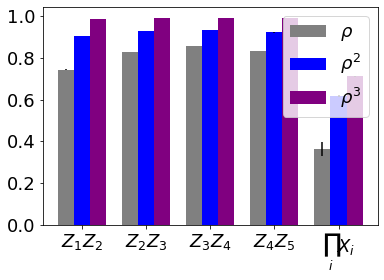

In [2]:
#Observable mean and variance (Fig.4 of https://arxiv.org/abs/2203.07309)

font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


N = 5
nsimu = 10000
n_average = 4
qubits = cirq.LineQubit.range(N)
circuit =  base(qubits)
observables = ["ZZIII","IZZII","IIZZI","IIIZZ","XXXXX"]
delta = {}
for obs in observables:
     for i in range(3):
          delta[obs+str(i)]=[]

simulator = cirq.Simulator()
simulation = simulator.simulate(circuit)
final_state = np.array([simulation.final_state_vector])
rho_actual = final_state.T@final_state

for _ in range(n_average):
    rho_shadow = find_rho_IBM(circuit,qubits,N,nsimu)
    rho_shadow2 = rho_shadow@rho_shadow
    rho_shadow3 = rho_shadow@rho_shadow2
    rho_shadow/=np.trace(rho_shadow)
    rho_shadow2/=np.trace(rho_shadow2)
    rho_shadow3/=np.trace(rho_shadow3)
    print("trace distance rho",trace_dist(rho_shadow,rho_actual))
    print("trace distance rho2",trace_dist(rho_shadow2,rho_actual))
    print("trace distance rho3",trace_dist(rho_shadow3,rho_actual))
    for obs in observables:
        O = 1.
        for o in obs:

            O = np.kron(obs_gate(o),O)
        print("obs rho actual:",np.trace(rho_actual@O))
        print("obs rho:",np.trace(rho_shadow@O)/np.trace(rho_shadow))
        print("obs rho2:",np.trace(rho_shadow2@O)/np.trace(rho_shadow2))
        print("obs rho3:",np.trace(rho_shadow3@O)/np.trace(rho_shadow3))
        delta[obs+str(0)].append(np.trace(rho_shadow@O)/np.trace(rho_shadow))
        delta[obs+str(1)].append(np.trace(rho_shadow2@O)/np.trace(rho_shadow2))
        delta[obs+str(2)].append(np.trace(rho_shadow3@O)/np.trace(rho_shadow3))

print(delta)

x1 = []
x2 = []
x3 = []
err_x1 = []
err_x2 = []
err_x3 = []
for obs in observables:
    for i in range(3):
        print("Mean"+obs+str(i)+": ",np.mean(delta[obs+str(i)]),"var"+obs+str(i)+": ",np.var(delta[obs+str(i)]))
    x1.append(np.mean(delta[obs+str(0)]))
    x2.append(np.mean(delta[obs+str(1)]))
    x3.append(np.mean(delta[obs+str(2)]))
    err_x1.append(np.var(delta[obs+str(0)]))
    err_x2.append(np.var(delta[obs+str(1)]))
    err_x3.append(np.var(delta[obs+str(2)]))


etiquette = [r'$Z_1Z_2$',r'$Z_2Z_3$',r'$Z_3Z_4$',r'$Z_4Z_5$',r'$\prod_i X_i$']
position = np.arange(len(etiquette))
largeur = .25

fig, ax = plt.subplots()
r1 = ax.bar(position - largeur, x1,yerr = err_x1,width =  largeur,color = "grey",label = r'$\rho$')
r2 = ax.bar(position , x2, yerr = err_x2,width = largeur,color = "blue",label = r'$\rho^2$')
r3 = ax.bar(position + largeur, x3,yerr = err_x3,width = largeur,color = "purple",label = r'$\rho^3$')
ax.set_xticks(position)
ax.set_xticklabels(etiquette)
plt.legend(loc='lower left')
plt.savefig("IBM_Mean_var_N_simu="+str(nsimu)+".png")
plt.show()

